## Introduction

We will explore the relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. we will combine the following data sets into a single, clean pandas dataframe:

- **[SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4)** - SAT scores for each high school in New York City


- **[School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt)** - Attendance information for each school in New York City


- **[Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)** - Information on class size for each school


- **[AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e)** - Advanced Placement (AP) exam results for each high school
(passing an optional AP exam in a particular subject can earn a student college
credit in that subject)


- **[Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a)** - The percentage of students who graduated, and other
outcome information


- **[Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j)** - Demographic information for each school


- **[School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8)** - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.



## Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Vizualization

There are several fields in combined that originally came from a survey of parents, teachers, and students. Will make a bar plot of the correlations between these fields and sat_score.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
survey_fields 

['DBN',
 'rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_10',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

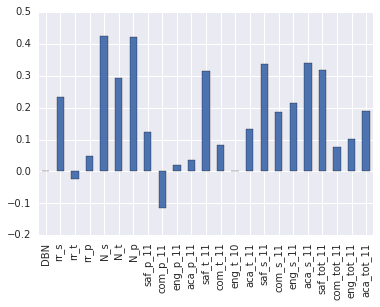

In [12]:
combined.corr()["sat_score"][survey_fields].plot.bar()

**Findings:** Noticing saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score.

**Next steps:** we will dig into this relationship a bit more, and try to figure out which schools have low safety scores

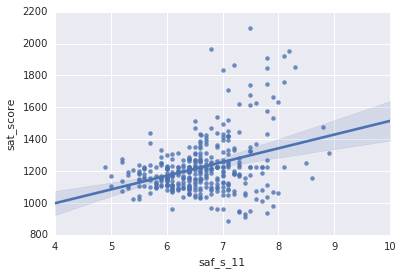

In [13]:
#fig, ax = plt.subplots()
#ax.scatter(x= combined['saf_s_11'], y=combined['sat_score'])
sns.regplot(x= combined['saf_s_11'], y=combined['sat_score'])

**Conclusions:** a little bit of a positive correlation mostly above 7.5 safety score

## Plotying safety

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

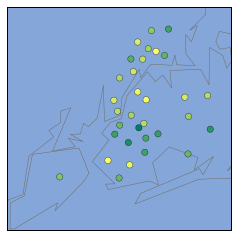

In [15]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=40, zorder=2, latlon=True, c=districts['saf_s_11'], cmap="summer" )
plt.show()

**Findings:** Brooklyn has the highest safety scores

## Investigating racial differences in SAT scores

There are a few columns that indicate the percentage of each race at a given school:

- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performanc

In [16]:
racial_columns = ["white_per", "asian_per", "black_per", "hispanic_per"]

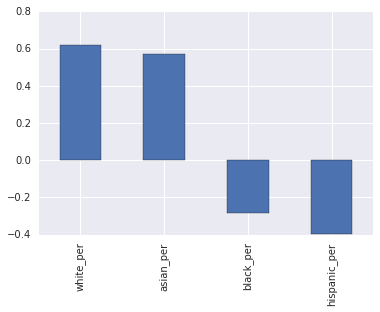

In [17]:
combined.corr()["sat_score"][racial_columns].plot.bar()

**Findings:** White and asian have high correlations unlike blakc and hispanic, we need to explore if black and hispanic low scores are from poor schools or not.

#### Exploring schools with low SAT scores and high values for hispanic_per.

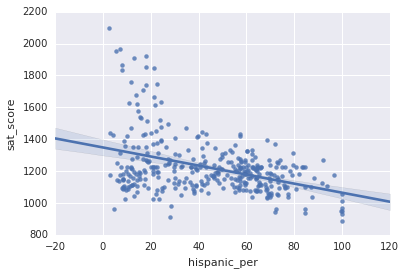

In [18]:
sns.regplot(x=combined['hispanic_per'], y=combined['sat_score'])

#### Research any schools with a hispanic_per greater than 95%.

In [19]:
hispanic_95 = combined[combined['hispanic_per'] > 95]
hispanic_95['School Name']

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

**Findings:** The above schools are mainly for immigrants who didn't study in the US from childhoold that's why their SAT scores are lower.

#### Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800

In [20]:
hispanic_10 = combined[(combined['hispanic_per'] <10) & (combined['sat_score'] >1800)]

In [21]:
hispanic_10['School Name']

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object

**Findings:** The above schools do require an entrance exam, thats way the tend to have high SAT scores, but the low hispanic percent is not obvious here.

## Exploring Gender And SAT SCores

There are two columns that indicate the percentage of each gender at a school:

- male_per

- female_per

We can plot out the correlations between each percentage and sat_score.

#### Investigate gender differences in SAT scores.

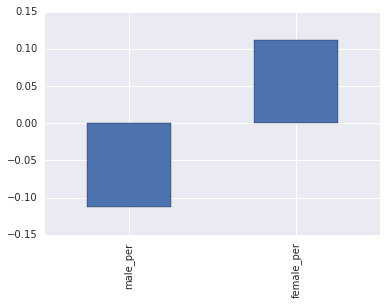

In [22]:
gender_columns = ['male_per', 'female_per']
combined.corr()['sat_score'][gender_columns].plot.bar()

**Findings:** not much of a correlation based on gender although femaled is higher

#### Investigate schools with high SAT scores and a high female_per

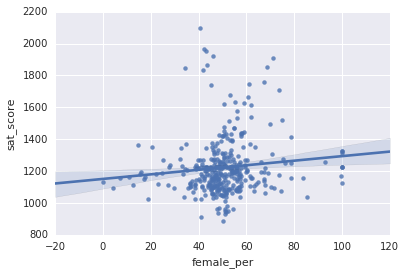

In [23]:
sns.regplot(x=combined['female_per'], y=combined['sat_score'])

**Obervations:** nothing to tell except that 40-60 percent cluster with average scores

#### Research schools with a female_per greater than 60% and an average SAT score greater than 1700

In [24]:
female_60 = combined[(combined['female_per'] >60)&(combined['sat_score'] > 1700)]

In [25]:
female_60['School Name']

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object

**Findings:** liberal arts schools with high academic standards

## Exploring AP Scores Vs. SAT Scores

In the U.S., high school students take [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams) (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

#### Calculate the percentage of students in each school that took an AP exam.

In [30]:
 combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

#### Investigate the relationship between AP scores and SAT scores

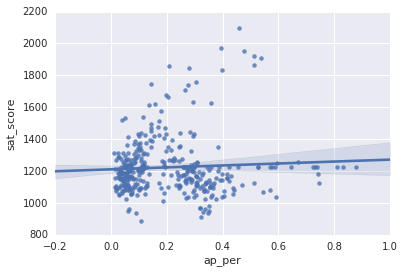

In [31]:
sns.regplot(x=combined['ap_per'], y= combined['sat_score'])

**Observations:** no correlation whatsoever

## Next Steps

We've done quite a bit of investigation into relationships between demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps

We've done quite a bit of investigation into relationships between demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps:

Determing wheter there's a correlation between class size and SAT scores
Figuring out which neighborhoods have the best schools
If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
Investigating the differences between parent, teacher, and student responses to surveys.
Assigning scores to schools based on sat_score and other attributes.
